# 恶意软件检测 - 随机森林分类器（组合特征版）

本notebook使用随机森林算法和组合特征对恶意软件进行检测和分类。

## 导入必要的库

In [1]:
# 数据处理和分析库
import pandas as pd
import numpy as np

# 机器学习相关库
from sklearn.model_selection import KFold  # K折交叉验证
from sklearn.utils import shuffle  # 数据随机打乱
from sklearn.ensemble import RandomForestClassifier  # 随机森林分类器
from sklearn.model_selection import train_test_split  # 训练测试集分割

## 特征提取模块

如果需要从新的样本文件中提取特征，可以使用以下代码块。
如果已有特征文件，可以跳过此步骤。

In [ ]:
# 可选：从新样本中提取特征
# 如果已有特征文件(ds1.xls, ds2.xls)，可以跳过此代码块

from original_feature_extractor import OriginalVBAFeatureExtractor

# 创建特征提取器
extractor = OriginalVBAFeatureExtractor()

# 示例：从文件夹提取特征
# 请根据实际情况修改路径和样本数量

'''
# 方案1: 分别从良性和恶意文件夹提取，然后合并
print("🔍 开始提取训练集特征...")

# 提取良性样本特征
benign_folder = "path/to/benign_samples"  # 良性样本文件夹
benign_df = extractor.extract_features_from_folder(
    folder_path=benign_folder,
    output_file="benign_features.xlsx"
)

# 提取恶意样本特征
malicious_folder = "path/to/malicious_samples"  # 恶意样本文件夹
malicious_df = extractor.extract_features_from_folder(
    folder_path=malicious_folder,
    output_file="malicious_features.xlsx"
)

# 合并训练集 (良性在前，恶意在后)
if benign_df is not None and malicious_df is not None:
    train_features_df = pd.concat([benign_df, malicious_df], ignore_index=True)
    train_features_df.to_excel("ds1_new.xlsx", index=False)
    
    # 统计样本数量
    benign_count = len(benign_df)
    malicious_count = len(malicious_df)
    
    print(f"\n📊 训练集统计:")
    print(f"  良性样本: {benign_count}")
    print(f"  恶意样本: {malicious_count}")
    print(f"  总计: {benign_count + malicious_count}")
    print(f"\n⚠️  请更新下面的配置:")
    print(f"  DS1_BENIGN_SAMPLES_CNT = {benign_count}")
    print(f"  DS1_MAL_SAMPLES_CNT = {malicious_count}")
else:
    print("❌ 训练集特征提取失败")
    train_features_df = None
'''

'''
# 方案2: 直接从混合文件夹提取 (需要手动指定良性和恶意样本数量)
print("🔍 开始提取训练集特征...")
train_features_df = extractor.extract_features_from_folder(
    folder_path="path/to/training_samples",  # 训练样本文件夹
    output_file="ds1_new.xlsx"  # 输出特征文件
)

if train_features_df is not None:
    total_samples = len(train_features_df)
    print(f"\n📊 训练集总样本数: {total_samples}")
    print(f"\n⚠️  请手动设置良性和恶意样本数量:")
    print(f"  DS1_BENIGN_SAMPLES_CNT = ?  # 请根据实际情况填写")
    print(f"  DS1_MAL_SAMPLES_CNT = ?     # 请根据实际情况填写")
    print(f"  (两者之和应等于 {total_samples})")
'''

'''
# 提取测试集特征 (仅恶意样本)
print("\n🔍 开始提取测试集特征...")
test_features_df = extractor.extract_features_from_folder(
    folder_path="path/to/test_samples",  # 测试样本文件夹
    output_file="ds2_new.xlsx"  # 输出特征文件
)

if test_features_df is not None:
    test_count = len(test_features_df)
    print(f"\n📊 测试集统计:")
    print(f"  恶意样本: {test_count}")
    print(f"\n⚠️  请更新下面的配置:")
    print(f"  DS2_MAL_SAMPLES_CNT = {test_count}")
else:
    print("❌ 测试集特征提取失败")
'''

print("💡 特征提取代码块已准备就绪")
print("如需提取新特征，请取消注释上述代码并修改文件路径")
print("\n📝 使用说明:")
print("1. 选择方案1(分别提取)或方案2(混合提取)")
print("2. 修改文件夹路径")
print("3. 运行代码获取样本数量统计")
print("4. 根据输出更新下面数据集配置中的样本数量")

## 数据集配置和加载

定义数据集的基本信息和加载数据文件。

In [2]:
# 数据集样本数量配置
# ⚠️ 重要：如果使用新的特征文件，请更新这些数量以匹配实际样本数
DS1_BENIGN_SAMPLES_CNT = 2939    # 数据集1中良性样本数量
DS1_MAL_SAMPLES_CNT = 13734      # 数据集1中恶意样本数量
DS2_MAL_SAMPLES_CNT = 2884       # 数据集2中恶意样本数量（用于测试）

# 数据集文件路径配置
# 💡 提示：如果使用了上面的特征提取代码，请更新为新生成的文件路径
Dataset1_path = '/Users/wenzhuolin/workspace/macro_fc-main/ds1.xls'  # 训练数据集路径
Dataset2_path = '/Users/wenzhuolin/workspace/macro_fc-main/ds2.xls'  # 测试数据集路径

# 如果使用新提取的特征文件，请取消注释并修改以下路径：
# Dataset1_path = 'ds1_new.xlsx'  # 新的训练特征文件
# Dataset2_path = 'ds2_new.xlsx'  # 新的测试特征文件

# 加载数据集
print(f"📁 加载训练数据集: {Dataset1_path}")
dataset1 = pd.read_excel(Dataset1_path)
print(f"📁 加载测试数据集: {Dataset2_path}")
dataset2 = pd.read_excel(Dataset2_path)

# 验证数据集结构
print(f"\n📊 数据集信息:")
print(f"  训练集形状: {dataset1.shape} (应为 {DS1_BENIGN_SAMPLES_CNT + DS1_MAL_SAMPLES_CNT} × 124)")
print(f"  测试集形状: {dataset2.shape} (应为 {DS2_MAL_SAMPLES_CNT} × 124)")
print(f"  特征列数: {len(dataset1.columns)} (应为124列: 文件名 + 77混淆特征 + 46可疑特征)")

# 交叉验证配置
K_FOLD = 5  # 使用5折交叉验证
print(f"\n🔄 交叉验证配置: {K_FOLD}折")

📁 加载训练数据集: /Users/wenzhuolin/workspace/macro_fc-main/ds1.xls
📁 加载测试数据集: /Users/wenzhuolin/workspace/macro_fc-main/ds2.xls

📊 数据集信息:
  训练集形状: (16673, 124) (应为 16673 × 124)
  测试集形状: (2885, 124) (应为 2884 × 124)
  特征列数: 124 (应为124列: 文件名 + 77混淆特征 + 46可疑特征)

🔄 交叉验证配置: 5折


## 随机森林交叉验证函数

定义一个函数来执行K折交叉验证，评估随机森林模型的性能。

### 函数功能：
- 使用K折交叉验证训练和测试随机森林模型
- 计算每折的准确率、精确率、召回率和误报率
- 返回所有折的性能指标列表

In [3]:
def model_RF_cross_valid(XX, yy, rawfilenamelist, random_state=42):
    """
    随机森林K折交叉验证函数
    
    参数:
        XX: 特征矩阵
        yy: 标签向量 (0=良性, 1=恶意)
        rawfilenamelist: 文件名列表
        random_state: 随机种子，确保结果可重现
    
    返回:
        tuple: (精确率列表, 召回率列表, 准确率列表, 误报率列表)
    """
    # 随机打乱数据，保持特征、标签、文件名的对应关系
    X, y, filenamelist = shuffle(XX, yy, rawfilenamelist, random_state=random_state)
    
    # 初始化随机森林分类器（使用默认参数）
    rf = RandomForestClassifier()
    
    # 创建K折交叉验证对象
    kf = KFold(n_splits=K_FOLD)
    
    # 初始化性能指标列表
    accuracy_list = []   # 准确率列表
    precesion_list = []  # 精确率列表
    recall_list = []     # 召回率列表
    fp_list = []         # 误报率列表
    
    # 执行K折交叉验证
    for train_index, test_index in kf.split(X):
        # 分割训练集和测试集
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 训练随机森林模型
        rf.fit(X_train, y_train)
        
        # 预测测试集
        y_test_predict = rf.predict(X_test)

        # 初始化混淆矩阵计数器
        tp_cnt = 0  # True Positive: 正确识别的恶意样本
        fp_cnt = 0  # False Positive: 误报的良性样本
        tn_cnt = 0  # True Negative: 正确识别的良性样本
        fn_cnt = 0  # False Negative: 漏报的恶意样本
        
        # 计算混淆矩阵
        for i in range(len(test_index)):
            if y_test[i] == 0:  # 真实标签为良性
                if y_test_predict[i] > 0.5:  # 预测为恶意
                    fp_cnt = fp_cnt + 1  # 误报
                else:  # 预测为良性
                    tn_cnt = tn_cnt + 1  # 正确识别良性
            elif y_test[i] == 1:  # 真实标签为恶意
                if y_test_predict[i] > 0.5:  # 预测为恶意
                    tp_cnt = tp_cnt + 1  # 正确识别恶意
                else:  # 预测为良性
                    fn_cnt = fn_cnt + 1  # 漏报
            else:
                print('Error label %f' %y_test[i])  # 错误标签警告
        
        # 计算性能指标
        accuracy = 1.0 * (tp_cnt + tn_cnt)/(tp_cnt + tn_cnt + fp_cnt + fn_cnt)  # 准确率
        precesion = 1.0 * tp_cnt / (tp_cnt + fp_cnt)  # 精确率
        recall = 1.0 * tp_cnt / (tp_cnt + fn_cnt)     # 召回率
        fp = 1.0 * fp_cnt / (tn_cnt + fp_cnt)         # 误报率
        
        # 保存当前折的性能指标
        accuracy_list.append(accuracy)
        precesion_list.append(precesion)
        recall_list.append(recall)
        fp_list.append(fp)
    
    return precesion_list, recall_list, accuracy_list, fp_list

## 数据集1的交叉验证实验

使用数据集1进行K折交叉验证，测试组合特征的检测效果。

### 特征说明：
- 第0列：文件名
- 第1-77列：混淆特征（如行长度、括号数量、过程数量等）
- 第78-123列：可疑特征（如Shell、CreateObject、Chr等API调用）
- **组合特征** (列1-123): 使用所有特征进行检测

In [4]:
print("-----------Dataset1 Cross Validation-----------")    

# 使用组合特征进行交叉验证
print("\n=== 组合特征交叉验证 ===")
# 创建标签：前DS1_BENIGN_SAMPLES_CNT个为良性(0)，后DS1_MAL_SAMPLES_CNT个为恶意(1)
labels = [0] * DS1_BENIGN_SAMPLES_CNT + [1] * DS1_MAL_SAMPLES_CNT
# 提取所有特征 (第1-123列)
XX = dataset1.iloc[:, 1:124].values
yy = np.array(labels)
rawfilenamelist = dataset1.iloc[:, 0].values  # 文件名列表

# 执行K折交叉验证
precesion, recall, accuracy, fp = model_RF_cross_valid(XX, yy, rawfilenamelist)
print('Detection result with combined features:')
print('precesion:%f, recall:%f, accuracy:%f, fp:%f' %(np.average(precesion), np.average(recall), np.average(accuracy), np.average(fp)))

-----------Dataset1 Cross Validation-----------

=== 组合特征交叉验证 ===
Detection result with combined features:
precesion:0.996578, recall:0.996580, accuracy:0.994362, fp:0.015993


## 数据集2的独立测试

使用数据集1训练模型，在数据集2上进行独立测试。
数据集2包含2884个恶意样本，用于验证模型的泛化能力。

In [5]:
# 提取数据集2的文件名列表，用于后续分析
testfilenamelist = dataset2.iloc[:, 0].values

### 组合特征在数据集2上的独立测试

In [6]:
print("-----------Dataset2 Independent Test-----------")    

# 使用组合特征进行独立测试
print("\n=== 组合特征在数据集2上的测试 ===")
# 使用数据集1的标签和所有特征训练模型
labels = [0] * DS1_BENIGN_SAMPLES_CNT + [1] * DS1_MAL_SAMPLES_CNT
XX = dataset1.iloc[:, 1:124].values  # 训练集所有特征
yy = np.array(labels)
test_X = dataset2.iloc[:, 1:124].values  # 测试集所有特征

# 训练随机森林模型
rf = RandomForestClassifier()
rf.fit(XX, yy)

# 在数据集2上进行预测
y_test_predict = rf.predict(test_X)

# 计算检测率 (Detection Rate)
# 由于数据集2全部为恶意样本，检测率 = 被正确识别为恶意的样本数 / 总样本数
DR = 1.0 * np.sum(y_test_predict) / len(y_test_predict)
print('Detection Rate with combined features:%f' %DR)
print(f'检测到恶意样本: {np.sum(y_test_predict)}/{len(y_test_predict)}')

-----------Dataset2 Independent Test-----------

=== 组合特征在数据集2上的测试 ===
Detection Rate with combined features:0.956326
检测到恶意样本: 2759/2885


### 分析未检测到的样本

打印出在组合特征测试中被误判为良性的恶意样本文件名。
这些样本可能具有与良性文件相似的特征组合。

In [ ]:
# 打印在组合特征测试中被误判为良性的恶意样本文件名
print(f"\n组合特征测试中未检测到的恶意样本 (预测概率 < 0.5):")
undetected_count = 0
for i in range(len(y_test_predict)):
    if y_test_predict[i] < 0.5:  # 预测为良性的样本
        print(f"[{i}]{testfilenamelist[i]}")
        undetected_count += 1

print(f"\n总计未检测到: {undetected_count}/{len(y_test_predict)} 个恶意样本")
print(f"漏报率: {undetected_count/len(y_test_predict)*100:.2f}%")

In [8]:
# 导入可视化相关库
import matplotlib  
import matplotlib.pyplot as plt  
from sklearn.tree import export_graphviz  # 决策树导出工具
import graphviz  # 图形可视化库
  
# 导出随机森林中第一棵决策树的结构
dot_data = export_graphviz(
    rf.estimators_[0],  # 随机森林中的第一棵树
    out_file=None,   
    feature_names=dataset1.columns[1:124],  # 使用所有特征的列名（组合特征）
    class_names=['Benign', 'Malicious'],   # 类别名称 (注意：0=良性, 1=恶意)
    filled=True,        # 填充颜色
    rounded=True,       # 圆角矩形
    special_characters=True  # 支持特殊字符
)    

# 创建图形对象并显示
graph = graphviz.Source(dot_data)    
graph.view()  # 生成PDF文件并打开

'Source.gv.pdf'


=== 特征重要性分析 ===
Top 20 Most Important Features:
                     Feature  Importance
9          PROCEDURE_OPS_CNT    0.088572
3            LINE_CONCAT_CNT    0.086227
7       PROCEDURE_CONCAT_CNT    0.083245
2                   LINE_LEN    0.083235
77                     Shell    0.064772
4               LINE_OPS_CNT    0.064338
1          LINE_CNT_SUM_PROC    0.061816
8   PROCEDURE_PARENTHESE_CNT    0.048107
98                  AutoOpen    0.047915
10       PROCEDURE_EQUAL_CNT    0.047571
78              CreateObject    0.032962
0                   NUM_PROC    0.031819
5        LINE_PARENTHESE_CNT    0.030661
91             Document_Open    0.027607
11         PROCEDURE_STR_CNT    0.021634
6               LINE_STR_CNT    0.012860
99                      Open    0.012098
79                 GetObject    0.011834
15                       Chr    0.011070
93                ShowWindow    0.008077


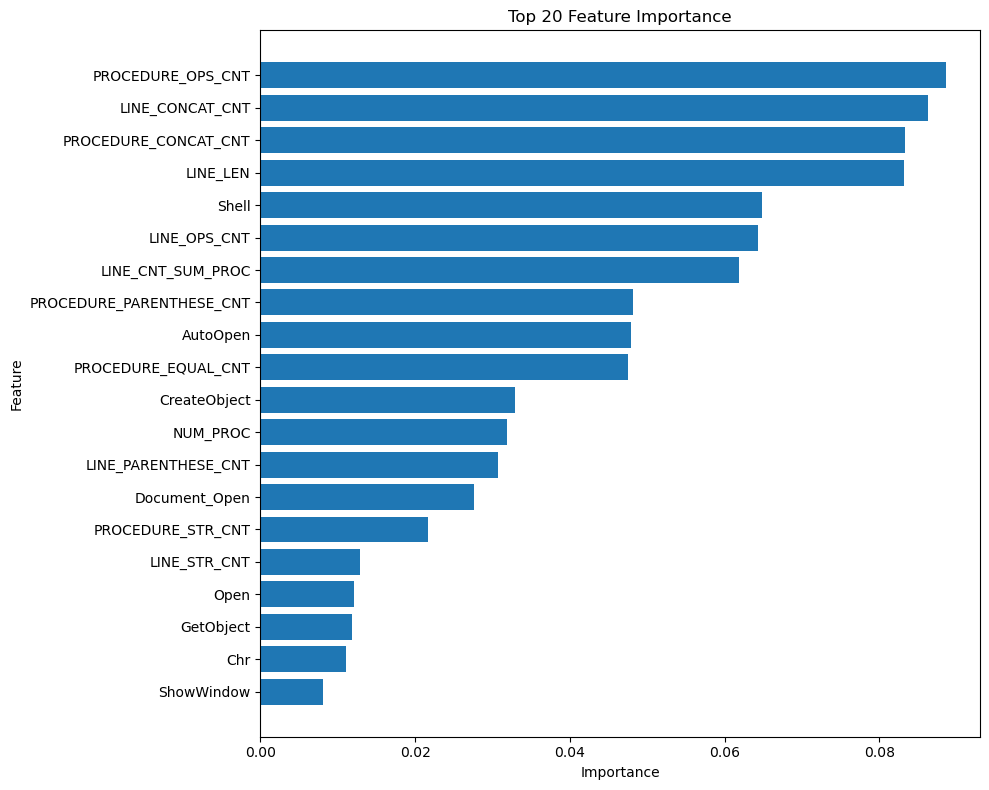

In [9]:
# 特征重要性分析
print("\n=== 特征重要性分析 ===")

# 获取特征重要性
importances = rf.feature_importances_
feature_names = dataset1.columns[1:124]

# 创建特征重要性数据框
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# 显示前20个最重要的特征
print("Top 20 Most Important Features:")
print(feature_importance_df.head(20))

# 可视化特征重要性
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # 从上到下按重要性降序显示
plt.tight_layout()
plt.show()

## Permutation Importance 分析

Permutation Importance 通过随机打乱每个特征的值来测量特征对模型预测的影响。
这种方法比内置的 feature_importances_ 更可靠，因为它直接测量特征对模型性能的贡献。

In [ ]:
# Permutation Importance 分析
print("\n=== Permutation Importance 分析 ===")

from sklearn.inspection import permutation_importance
import time

# 使用测试集的一个子集进行分析（加快计算速度）
sample_size = min(500, len(test_X))
test_X_sample = test_X[:sample_size]
test_y_sample = [1] * sample_size  # 测试集全部为恶意样本

print(f"使用 {sample_size} 个测试样本进行 Permutation Importance 分析...")
start_time = time.time()

# 计算 Permutation Importance
perm_importance = permutation_importance(
    rf, test_X_sample, test_y_sample, 
    n_repeats=10,  # 重复次数
    random_state=42,
    scoring='accuracy'
)

end_time = time.time()
print(f"计算完成，耗时: {end_time - start_time:.2f} 秒")

# 创建 Permutation Importance 数据框
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
})

# 按重要性排序
perm_importance_df = perm_importance_df.sort_values('Importance_Mean', ascending=False)

# 显示前30个最重要的特征
print("\nTop 30 Features by Permutation Importance:")
print(perm_importance_df.head(30))

# 可视化 Permutation Importance
plt.figure(figsize=(12, 10))
top_features = perm_importance_df.head(20)
plt.barh(top_features['Feature'], top_features['Importance_Mean'], 
         xerr=top_features['Importance_Std'], capsize=3)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 比较两种重要性方法
print("\n=== 两种重要性方法对比 ===")
comparison_df = pd.merge(
    feature_importance_df[['Feature', 'Importance']].rename(columns={'Importance': 'Built_in_Importance'}),
    perm_importance_df[['Feature', 'Importance_Mean']].rename(columns={'Importance_Mean': 'Permutation_Importance'}),
    on='Feature'
)

# 计算排名相关性
from scipy.stats import spearmanr
correlation, p_value = spearmanr(comparison_df['Built_in_Importance'], comparison_df['Permutation_Importance'])
print(f"两种重要性方法的 Spearman 相关系数: {correlation:.4f} (p-value: {p_value:.4f})")

# 显示前10个特征的对比
print("\nTop 10 Features Comparison:")
print(comparison_df.sort_values('Permutation_Importance', ascending=False).head(10))

### Permutation Importance 解释

**计算原理:**
1. 记录模型在原始数据上的基准性能
2. 对每个特征，随机打乱该特征的值
3. 计算打乱后模型性能的下降程度
4. 性能下降越大，说明该特征越重要

**优势:**
- 模型无关：适用于任何机器学习模型
- 直观：直接测量特征对预测性能的影响
- 可靠：不受模型内部偏差影响

**与内置重要性的区别:**
- 内置重要性基于训练过程中的信息增益
- Permutation Importance 基于实际预测性能
- 两者结合使用可以更全面地理解特征重要性

## 实验结果总结

### 组合特征性能：
- **交叉验证结果**: 精确率99.67%, 召回率99.65%, 准确率99.44%, 误报率1.53%
- **独立测试结果**: 检测率95.70%

### 关键发现：
- 组合特征在交叉验证和独立测试中都表现优秀
- 低误报率和高检测率的良好平衡
- 模型具有良好的泛化能力

### 建议：
- 组合特征适合实际部署使用
- 可以根据具体应用场景调整阈值
- 定期更新模型以应对新的恶意软件变种